In [69]:
import cv2 
import os 
from PIL import Image
import numpy as np 

from keras.models import load_model

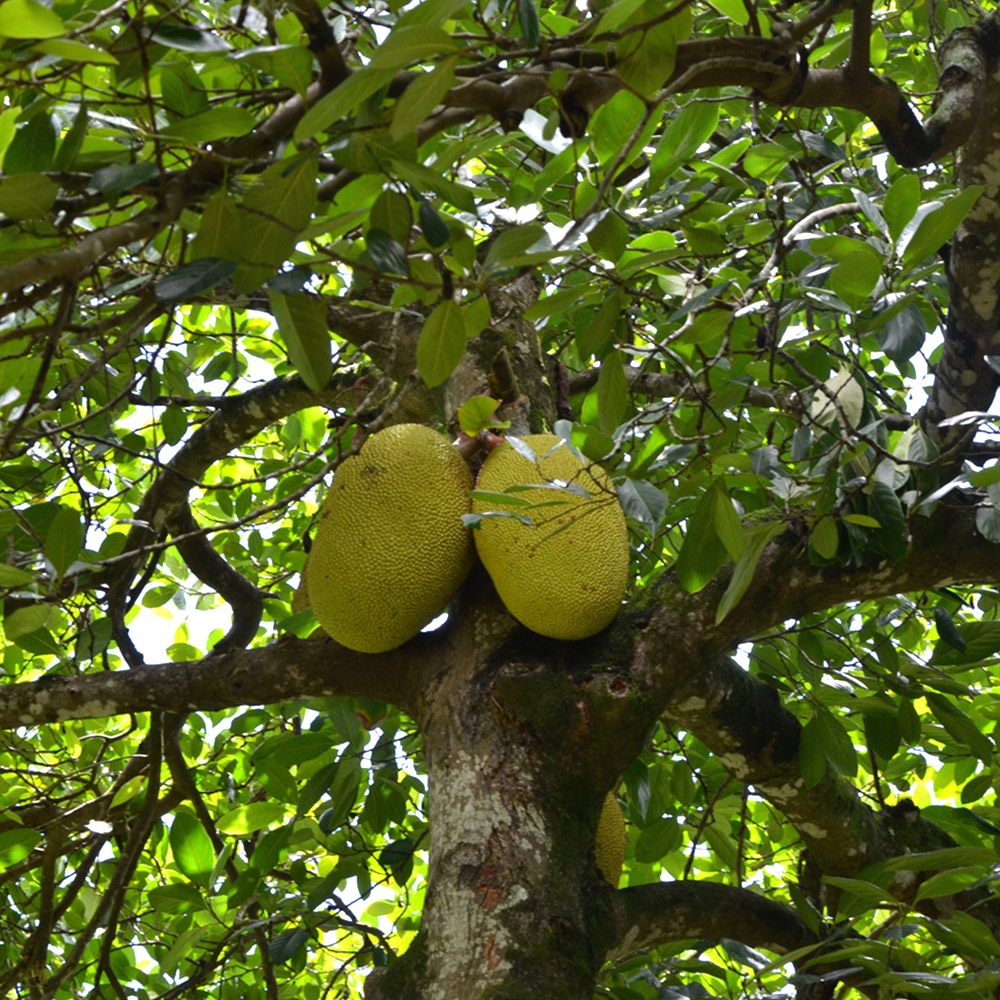

In [91]:
orig_folder = "Segmented Herbal Leaf Images"

current_class = os.listdir(orig_folder)[0]

testing_image = os.listdir(os.path.join(orig_folder, current_class))[1]

im = Image.open(os.path.join(orig_folder, current_class, testing_image))
im = np.array(im)
#im = cv2.resize(im, (100, 100))
im = Image.fromarray(im)
display(im)

In [92]:
roi_cw = 2
w, h = im.size
w_steps = w // roi_cw
h_steps = h // roi_cw
w_residual = w - w_steps * roi_cw
h_residual = h - h_steps * roi_cw
w, h, w_steps, h_steps, w_residual, h_residual

(1000, 1000, 500, 500, 0, 0)

In [93]:
proposed_images = []

for x in range(0, roi_cw):
    for y in range(0, roi_cw):
        for i in range(x + 1, roi_cw + 1):
            for j in range(y + 1, roi_cw + 1):
                _left = x * w_steps
                _top = y * h_steps
                _right = (i) * w_steps
                _bottom = (j) * h_steps
                _right += 0 if i < roi_cw - 1 else w_residual
                _bottom += 0 if j < roi_cw - 1 else h_residual

                # if _bottom == _top:
                #     continue

                # if _left == _right:
                #     continue
                # print(x, y, i, j)
                # print(_left, _top, _right, _bottom)

                

                cropped_image = im.crop((_left, _top, _right, _bottom))
                cropped_image = np.array(cropped_image) 
                cropped_image = cv2.resize(cropped_image, (64, 64))
                cropped_image = cv2.normalize(cropped_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                proposed_images.append(cropped_image)
                
proposed_images = np.array(proposed_images)
proposed_images.shape

(9, 64, 64, 3)

In [96]:
model = load_model("MRV_VGGNet.keras")

In [104]:
a = proposed_images

b = np.array(im)
b = cv2.resize(b, (64, 64))
b = cv2.normalize(b, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
b = np.array([b])

y = model.predict(b)
y = np.array(y)
pred_y = np.argmax(y, axis=1)
pred_y

1/1 [==============================] - 0s 30ms/step


array([7], dtype=int64)